In [13]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from deepxde.backend import torch


Exercício 5(a) – Sistema Massa-Mola-Amortecedor Não Forçado (DeepXDE)

Neste exercício, implementaremos uma PINN utilizando DeepXDE para resolver o problema do sistema massa-mola-amortecedor não forçado. O objetivo é comparar a solução obtida pela rede neural com a solução analítica.

In [14]:
# Parâmetros físicos
m = 1.0
k = 4.0
c = 0.4

omega_n = np.sqrt(k / m)
zeta = c / (2 * np.sqrt(k * m))
omega_d = omega_n * np.sqrt(1 - zeta**2)

print(f"ωn = {omega_n:.4f}, ζ = {zeta:.4f}, ωd = {omega_d:.4f}")


ωn = 2.0000, ζ = 0.1000, ωd = 1.9900


In [15]:
def solucao_analitica(t):
    exp_term = np.exp(-zeta * omega_n * t)
    cos_term = np.cos(omega_d * t)
    sin_term = np.sin(omega_d * t)
    fator = zeta * omega_n / omega_d
    return exp_term * (cos_term + fator * sin_term)


In [16]:
# Domínio temporal
geom = dde.geometry.TimeDomain(0, 5)

# Equação diferencial via PINN
def ode(t, y):
    dy_t = dde.grad.jacobian(y, t, i=0, j=0)
    dy_tt = dde.grad.hessian(y, t, component=0, i=0, j=0)
    return m * dy_tt + c * dy_t + k * y

# Condições iniciais
ic_x = dde.IC(geom, lambda t: 1, lambda _, on_initial: on_initial, component=0)
ic_v = dde.OperatorBC(geom, lambda t, y, _: dde.grad.jacobian(y, t)[:, 0:1], lambda _, on_initial: on_initial)

data = dde.data.PDE(geom, ode, [ic_x, ic_v], num_domain=200, num_boundary=10)


In [17]:
net = dde.maps.FNN([1] + [50]*3 + [1], activation="tanh", kernel_initializer="Glorot normal")

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
loss_history, train_state = model.train(epochs=5000)


Compiling model...
'compile' took 0.000396 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.40e+00, 1.00e+00, 4.29e-02]    [6.40e+00, 1.00e+00, 4.29e-02]    []  
1000      [1.07e-01, 2.29e-02, 1.74e-02]    [1.07e-01, 2.29e-02, 1.74e-02]    []  
2000      [1.52e-02, 5.22e-04, 4.32e-03]    [1.52e-02, 5.22e-04, 4.32e-03]    []  
3000      [1.42e-02, 3.85e-04, 4.33e-03]    [1.42e-02, 3.85e-04, 4.33e-03]    []  
4000      [1.41e-02, 3.67e-04, 4.29e-03]    [1.41e-02, 3.67e-04, 4.29e-03]    []  
5000      [1.40e-02, 3.62e-04, 4.27e-03]    [1.40e-02, 3.62e-04, 4.27e-03]    []  

Best model at step 5000:
  train loss: 1.87e-02
  test loss: 1.87e-02
  test metric: []

'train' took 18.570586 s



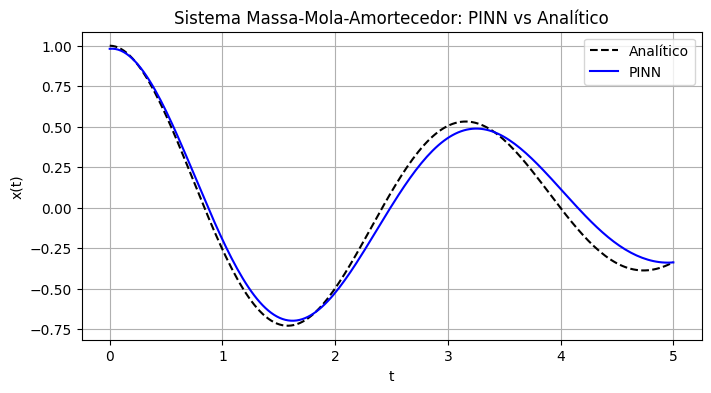

In [18]:
# Teste nos pontos
t = np.linspace(0, 5, 200)[:, None]
x_pinn = model.predict(t)
x_analitico = solucao_analitica(t)

plt.figure(figsize=(8,4))
plt.plot(t, x_analitico, "k--", label="Analítico")
plt.plot(t, x_pinn, "b", label="PINN")
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Sistema Massa-Mola-Amortecedor: PINN vs Analítico")
plt.savefig('../imagens/Massa_Mola_Amortecedor.png')
plt.show()
